In [110]:
import qmps
import xmps
import cirq
from xmps import iMPS
import numpy as np
def ap(A, _abs = True):
    if _abs:
        print(np.around(np.abs(A), 2))
    else:
        print(np.around(A, 2))

In [23]:
from numpy.linalg import svd

def S(ρ):
    # S = Σᵢρᵢlog(ρᵢ) where ρᵢ = |λᵢ|^2 and λᵢ = singular values 
    u, s, v = svd(ρ) 
    s = np.square(np.abs(s)) 
    return np.dot(np.log2(s), s)
    

### Alternating Hamiltonians to get 3 state evolution (didn't work)

### Finding Parameterization of the 2 parameter scar mps

In [5]:
A = lambda ϕ, θ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                          [[np.cos(θ), 0],
                           [np.sin(θ), 0]]])

U = lambda θ, ϕ: np.array([
    [0,1j*np.exp(-1j*ϕ),0,0],
    [np.cos(θ), 0, 0, -np.sin(θ)],
    [0,0,1,0],
    [np.sin(θ), 0, 0, np.cos(θ)]
])

for x,y in zip(np.random.randn(10), np.random.randn(10)):
    assert np.allclose(U(x,y).conj().T@U(x,y), np.eye(4))

#### Exact Hamiltonian for simulation

In [34]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.represent import Tensor
def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

In [6]:
from qmps.time_evolve_tools import merge

# bUILDING THE TWO SITES FROM As

def two_site_As(θ, ϕ, θ_, ϕ_):
    A1 = A(ϕ, θ)
    A2 = A(ϕ_, θ_)
    return merge(A1,A2)

def generate_two_site_unitary(params):
    return tensor_to_unitary(two_site_As(*params))

##### Using the Direct Parametrization to build the 2-site unitary:

In [67]:
class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']
        
    def num_qubits(self):
        return 3
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
u_scar = ScarGate([1,2,3,4])

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops([cirq.decompose_once(u_scar.on(*q))])
print(c)
        

0: ───X───────────────────────────────────────────@───X───X──────────S───
                                                  │       │
1: ───X─────────@───X───X───────────S───Z^0.137───X───────@^(7/11)───────
                │       │
2: ───Z^0.773───X───────@^(-1/11)────────────────────────────────────────


##### Trying to get the environment exactly

In [72]:
import sympy as sp
from sympy import symbols,init_printing, I
init_printing(use_latex='mathjax')

θ1, ϕ1, θ2, ϕ2 = symbols('theta_1 phi_1 theta_2 phi_2', real = True)
θ1, ϕ2

A_sp = lambda θ, ϕ: sp.Array([[[0, I*sp.exp(-I*ϕ)], 
                               [0,0]],
                               [[sp.cos(θ), 0],
                               [sp.sin(θ), 0]]])




A1 = A_sp(θ1, ϕ1)
A2 = A_sp(θ2, ϕ2)

from sympy import tensorproduct, tensorcontraction, permutedims

def merge_sp(A1, A2):
    # Merge two Bond Dim 2 Matrix Product States using Sympy
    contracted = tensorcontraction(tensorproduct(A1,A2),(2,4))
    permuted = permutedims(contracted, (0,2,1,3))
    return permuted.reshape(4,2,2)

A12 = merge_sp(A1,A2)
A12 [2,:,:] 

def transfer_matrix_sp(A12):
    # contract two 'merged' objects on their physical index, and group the remaining indices so it is a 4x4 matrix
    flipped = permutedims(A12, (0,1,2))
    flipped = flipped.conjugate()
    contracted = tensorcontraction(tensorproduct(A12, flipped),(0,3))
    grouped = permutedims(contracted,(0,2,1,3))
    return grouped.reshape(4,4).tomatrix()

tm = transfer_matrix_sp(A12)

result = tm.eigenvects()
environment = result[1][2][0].reshape(2,2)
environment

⎡                                        2                                    
⎢                                    -cos (θ₁)                                
⎢                         ────────────────────────────────                    
⎢                            2          2        2                            
⎢                         sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1                    
⎢                                                                             
⎢ ⎛⎛   2          2        2        ⎞                              3        2 
⎢-⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)⋅cos(θ₁) - sin(θ₁)⋅cos (θ₁)⋅cos (
⎢─────────────────────────────────────────────────────────────────────────────
⎢                             2          2        2                           
⎣                        - sin (θ₂) - cos (θ₁)⋅cos (θ₂) + 1                   

        ⎛⎛   2          2        2        ⎞                              3    
       -⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)

The analytical expression is not that useful since it appears too complicated to easily express with rotation gates

##### Making the Hamiltonian:

In [99]:
# How to build custom controlled gates:
# - IMPORTANT: LATER VERSIONS OF CIRQ HAVE CHANGED CONTROLLED GATE AND THIS WILL HAVE TO BE CHANGE IF WE UPDATE

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops(
    cirq.ControlledGate(
        sub_gate=cirq.XPowGate(),
        num_controls = 2, 
        control_qubits=[q[0], q[2]]).on(q[1])   
)


In [4]:
class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()

    




0: ───X───@─────────X─────────────────
          │
1: ───────X─────────X───@─────────X───
          │             │
2: ───X───@^0.032───X───X─────────────
                        │
3: ───X─────────────────@^0.032───X───


In [18]:
from xmps.iMPS import Map
from qmps.time_evolve_tools import put_env_on_right_site, put_env_on_left_site
from qmps.represent import Environment 

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])


ham = PXPHamiltonian(0.1)

def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, θ2, ϕ2]
    '''    
    θ1, ϕ1, θ2, ϕ2 = current_params
    θ1_,ϕ1_,θ2_, ϕ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

scars_time_evolve_cost_function(current_params, current_params, hamiltonian)

-0.9999904036521912

In [22]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
timesteps = 2000
hamiltonian = PXPHamiltonian(0.01)
current_params = [0,np.random.randn(1)[0], np.pi/2, np.random.randn(1)[0]]
final_params = []

for _ in tqdm(range(timesteps)):
    final_params.append(current_params)
    initial_params = current_params
    res = minimize(scars_time_evolve_cost_function, initial_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
    current_params = res.x

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 90
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 98
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 29
         Function evaluations: 92
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 101
Optimization terminated 

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 112
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 99
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 109
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 46
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 47
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 172
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 163
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 205
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 189
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 212
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 191
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 203
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 218
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 71
         Function evaluations: 234
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 81
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 72
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 89
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 85
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 256
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 87
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 82
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 92
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 88
         Function evaluations: 262
Optimization termina

## Putting it all together:

In [ ]:
#### Use this for a shallow representation of the PXP, 
#### otherwise use the W lambda function which is exact but might be really deep on chip ###

class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()


In [142]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.represent import Tensor, Environment
from qmps.tools import tensor_to_unitary
import cirq
from qmps.time_evolve_tools import merge, put_env_on_left_site, put_env_on_right_site
from xmps.iMPS import Map
from scipy.optimize import minimize
from tqdm.notebook import tqdm 

def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

class ScarsAnsatz(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ]
        
    def num_qubits(self):
        return 2
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ = self.params
        return [
            cirq.ZPowGate(exponent=1/2 - ϕ/π).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),  # global_shift is needed to remove erronous complex numbers
            cirq.S.on(q[0]),
            cirq.ZPowGate(exponent=-θ/π).on(q[1])
        ]

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, ϕ', θ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, ϕ_, θ_ = self.params
        return [
            ScarsAnsatz([θ_, ϕ_]).on(*q[1:3]),
            ScarsAnsatz([θ, ϕ]).on(*q[0:2])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])


def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    θ1, ϕ1, ϕ2, θ2 = current_params
    θ1_, ϕ1_, ϕ2_, θ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def scars_cost_fun_alternate(params, current_params, ham):
    '''
    This cost function doesn't use the quantum circuit parameterisation
    
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    θ1, ϕ1, ϕ2, θ2 = current_params
    θ1_, ϕ1_, ϕ2_, θ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    A12 = merge(A1,A2)
    A12_= merge(A1_,A2_)
    
    _, r = Map(A12, A12_).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = Tensor(tensor_to_unitary(A12),'U')
    U12_= Tensor(tensor_to_unitary(A12_),'U\'')
    
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def simulate_scars(dt, timesteps, μ, initial_params, save_file = None):
    hamiltonian = W(μ, dt)
    final_params = []
    current_params = initial_params
    for _ in tqdm(range(timesteps)):
        final_params.append(np.mod(current_params, 2*np.pi))
        res = minimize(scars_time_evolve_cost_function, current_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
        current_params = res.x
    
    if save_file:
        np.save(save_file, np.array(final_params))
    
    return np.array(final_params)
    

#### ODE Analytical Solver:

In [149]:
# Using tensor_to_unitary we almost exactly recreate the exact TDVP differential equation solutions.

from numpy import sin, cos, tan, arcsin, pi
import numpy as np
from scipy.integrate import odeint
dθdt = lambda θ1, ϕ1, ϕ2, θ2: tan(θ2)*sin(θ1)*(cos(θ1)**2)*cos(ϕ1) + cos(θ2)*cos(ϕ2)
dϕdt = lambda θ1, ϕ1, ϕ2, θ2: 2*tan(θ1)*cos(θ2)*sin(ϕ2) - 0.5*tan(θ2)*cos(θ1)*sin(ϕ1)*(2*(sin(θ2)**-2) + 
                                                                                                cos(2*θ1) - 5)

def func_list(angles,t,μ):
    return[dθdt(*angles), -μ + dϕdt(*angles), -μ + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]

np.random.seed(0)

y0 = np.random.randn(4)
steps = 10000
t = np.linspace(0.0, 500, steps)
dt = 4 * t[1]-t[0]
μ = 0.325

classical_angles = np.mod(odeint(func_list, y0, t, args=(μ,)), np.pi * 2)
quantum_angles = simulate_scars(dt, steps, μ, y0, save_file=f'{steps}_{dt}_{μ}_random_initial')


Optimization terminated successfully.
         Current function value: -0.996558
         Iterations: 102
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.996505
         Iterations: 83
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.996524
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.996613
         Iterations: 76
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.996765
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.996936
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.997101
         Iterations: 73
         Function evaluations: 150
Optimization termin

Optimization terminated successfully.
         Current function value: -0.997330
         Iterations: 55
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.997445
         Iterations: 56
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.997553
         Iterations: 65
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.997654
         Iterations: 51
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.997747
         Iterations: 66
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.997831
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.997907
         Iterations: 68
         Function evaluations: 135
Optimization termina

Optimization terminated successfully.
         Current function value: -0.996959
         Iterations: 55
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.997122
         Iterations: 60
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.997285
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.997448
         Iterations: 57
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.997607
         Iterations: 45
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.997763
         Iterations: 55
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.997912
         Iterations: 74
         Function evaluations: 149
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.995287
         Iterations: 78
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.995286
         Iterations: 78
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.995290
         Iterations: 62
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.995300
         Iterations: 75
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.995318
         Iterations: 79
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.995345
         Iterations: 95
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.995380
         Iterations: 72
         Function evaluations: 156
Optimization termina

Optimization terminated successfully.
         Current function value: -0.996368
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.996239
         Iterations: 59
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.996120
         Iterations: 77
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.996010
         Iterations: 61
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.995910
         Iterations: 76
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.995818
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.995735
         Iterations: 71
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998983
         Iterations: 52
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.998992
         Iterations: 54
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.998984
         Iterations: 61
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.998961
         Iterations: 59
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.998922
         Iterations: 61
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.998869
         Iterations: 55
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.998801
         Iterations: 66
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998008
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.998016
         Iterations: 57
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.998025
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.998036
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.998048
         Iterations: 59
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.998062
         Iterations: 58
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.998072
         Iterations: 60
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.997542
         Iterations: 62
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.997647
         Iterations: 62
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.997741
         Iterations: 61
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.997821
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.997885
         Iterations: 59
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.997934
         Iterations: 66
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.997967
         Iterations: 63
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.997630
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.997600
         Iterations: 58
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.997576
         Iterations: 59
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.997561
         Iterations: 68
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.997553
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.997555
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.997565
         Iterations: 56
         Function evaluations: 114
Optimization termina

Optimization terminated successfully.
         Current function value: -0.997692
         Iterations: 56
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.997753
         Iterations: 52
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.997826
         Iterations: 59
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.997905
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.997991
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.998082
         Iterations: 51
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.998177
         Iterations: 52
         Function evaluations: 116
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998338
         Iterations: 54
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.998339
         Iterations: 65
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.998342
         Iterations: 61
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.998346
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.998356
         Iterations: 63
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.998369
         Iterations: 63
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.998386
         Iterations: 73
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998222
         Iterations: 56
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.998283
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.998347
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.998411
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.998474
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.998534
         Iterations: 59
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.998589
         Iterations: 59
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998822
         Iterations: 61
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.998806
         Iterations: 60
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.998793
         Iterations: 59
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.998783
         Iterations: 67
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.998775
         Iterations: 57
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.998771
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.998768
         Iterations: 60
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.998648
         Iterations: 62
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.998597
         Iterations: 69
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.998547
         Iterations: 70
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.998501
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.998461
         Iterations: 64
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.998428
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.998405
         Iterations: 56
         Function evaluations: 117
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999420
         Iterations: 65
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999414
         Iterations: 65
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 61
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999367
         Iterations: 64
         Function evaluations: 135
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 64
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 80
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 58
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 58
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999370
         Iterations: 62
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999361
         Iterations: 63
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999350
         Iterations: 63
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999486
         Iterations: 63
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999495
         Iterations: 67
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999504
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999512
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999522
         Iterations: 62
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999531
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999540
         Iterations: 63
         Function evaluations: 124
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999117
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999148
         Iterations: 65
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999180
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999211
         Iterations: 62
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999240
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999269
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999297
         Iterations: 64
         Function evaluations: 136
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999121
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999122
         Iterations: 71
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999125
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999130
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999137
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999146
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999157
         Iterations: 65
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999313
         Iterations: 62
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999292
         Iterations: 61
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999273
         Iterations: 56
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999254
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999236
         Iterations: 82
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999220
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999205
         Iterations: 75
         Function evaluations: 146
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999478
         Iterations: 69
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999467
         Iterations: 61
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999454
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999440
         Iterations: 56
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999425
         Iterations: 60
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 60
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999606
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999608
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999609
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999610
         Iterations: 72
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999609
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999608
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999607
         Iterations: 62
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999296
         Iterations: 64
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999315
         Iterations: 61
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999333
         Iterations: 75
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999351
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999369
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 58
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 59
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999220
         Iterations: 61
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999227
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999234
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999243
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999253
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999264
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999275
         Iterations: 66
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 62
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 60
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999365
         Iterations: 64
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999349
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999333
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999318
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999303
         Iterations: 64
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999507
         Iterations: 67
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999501
         Iterations: 58
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999494
         Iterations: 64
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999487
         Iterations: 63
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999479
         Iterations: 70
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999470
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999460
         Iterations: 65
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999531
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999539
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999544
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999550
         Iterations: 69
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999555
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999559
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999563
         Iterations: 69
         Function evaluations: 138
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999275
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999284
         Iterations: 71
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999293
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999303
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999314
         Iterations: 69
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999325
         Iterations: 62
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999336
         Iterations: 59
         Function evaluations: 120
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999278
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999273
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999269
         Iterations: 64
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999266
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999265
         Iterations: 77
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999266
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999266
         Iterations: 64
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999499
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999490
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999481
         Iterations: 63
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999470
         Iterations: 62
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999460
         Iterations: 60
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999448
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999437
         Iterations: 64
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999495
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999499
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999501
         Iterations: 71
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999503
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999504
         Iterations: 62
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999505
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999504
         Iterations: 69
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999420
         Iterations: 57
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999429
         Iterations: 60
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999439
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999449
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999458
         Iterations: 65
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999290
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999286
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999282
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999279
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999278
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999278
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999278
         Iterations: 70
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 68
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999365
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999357
         Iterations: 65
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999520
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999521
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999520
         Iterations: 61
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999520
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999518
         Iterations: 62
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999515
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999512
         Iterations: 64
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 67
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 66
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 65
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999417
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999424
         Iterations: 60
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999430
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999436
         Iterations: 59
         Function evaluations: 120
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999311
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999313
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999317
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999322
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999326
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999332
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999338
         Iterations: 59
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999412
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 63
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999365
         Iterations: 83
         Function evaluations: 158
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999478
         Iterations: 71
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999477
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999476
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999474
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999472
         Iterations: 72
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999469
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999466
         Iterations: 78
         Function evaluations: 147
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999430
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999436
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999442
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999447
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999452
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999457
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999462
         Iterations: 65
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999320
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999321
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999323
         Iterations: 71
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999326
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999329
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999332
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999336
         Iterations: 65
         Function evaluations: 121
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 62
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999371
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999364
         Iterations: 61
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999359
         Iterations: 60
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999353
         Iterations: 64
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999475
         Iterations: 67
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999473
         Iterations: 61
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999472
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999470
         Iterations: 62
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999467
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999465
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999461
         Iterations: 69
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999415
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999420
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999425
         Iterations: 73
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999430
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999435
         Iterations: 69
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999439
         Iterations: 67
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999340
         Iterations: 61
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999342
         Iterations: 66
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999343
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999345
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999348
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999350
         Iterations: 60
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999353
         Iterations: 59
         Function evaluations: 117
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 62
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 68
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999367
         Iterations: 69
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999454
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999453
         Iterations: 68
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999451
         Iterations: 59
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999449
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999447
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999444
         Iterations: 68
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999442
         Iterations: 70
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999422
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999425
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999429
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999432
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999435
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999437
         Iterations: 65
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999341
         Iterations: 67
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999342
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999344
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999345
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999346
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999348
         Iterations: 64
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999350
         Iterations: 64
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 67
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 65
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999455
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999453
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999451
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999450
         Iterations: 69
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999448
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999445
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999443
         Iterations: 70
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 58
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 62
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999415
         Iterations: 63
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999419
         Iterations: 63
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999353
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999354
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999356
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999358
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999360
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999363
         Iterations: 58
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.999365
         Iterations: 63
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 59
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 60
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 66
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999436
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999435
         Iterations: 63
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999434
         Iterations: 67
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999434
         Iterations: 67
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999433
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999432
         Iterations: 61
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999431
         Iterations: 73
         Function evaluations: 142
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 67
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999414
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999417
         Iterations: 61
         Function evaluations: 119
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999355
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999355
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999354
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999355
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999355
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999355
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999356
         Iterations: 66
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 70
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 62
         Function evaluations: 121
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999434
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999434
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999433
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999433
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999433
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999432
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999431
         Iterations: 69
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 59
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 56
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 68
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999359
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999358
         Iterations: 63
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999359
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999359
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999360
         Iterations: 60
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999361
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999362
         Iterations: 60
         Function evaluations: 122
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999414
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 71
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 62
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 66
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999424
         Iterations: 67
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999425
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999426
         Iterations: 67
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999427
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999427
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999427
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999427
         Iterations: 69
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 59
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 60
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 57
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 61
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 63
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 64
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999371
         Iterations: 59
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999370
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999369
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999368
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999367
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999366
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999366
         Iterations: 62
         Function evaluations: 124
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999413
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999401
         Iterations: 68
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999412
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999413
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999414
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999415
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999416
         Iterations: 69
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 67
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 65
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 65
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 70
         Function evaluations: 136
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999374
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999371
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999370
         Iterations: 75
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999412
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 59
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 60
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 74
         Function evaluations: 146
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999412
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999414
         Iterations: 64
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999374
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 63
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 69
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999378
         Iterations: 58
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999378
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 73
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 65
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999418
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999417
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999416
         Iterations: 73
         Function evaluations: 139
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 71
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 70
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999374
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 65
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 78
         Function evaluations: 144
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 67
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 76
         Function evaluations: 144
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 69
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 66
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 64
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 60
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 61
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 66
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 77
         Function evaluations: 150
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 60
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 61
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 61
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999411
         Iterations: 68
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 74
         Function evaluations: 142
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 67
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 67
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 66
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 67
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 70
         Function evaluations: 135
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 72
         Function evaluations: 135
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 75
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 64
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999379
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999378
         Iterations: 63
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999376
         Iterations: 65
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 70
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 66
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999400
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 79
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999403
         Iterations: 76
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999404
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 69
         Function evaluations: 135
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999372
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 71
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999410
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999409
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999408
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999407
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999406
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999405
         Iterations: 75
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 66
         Function evaluations: 124
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 62
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 65
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 62
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 62
         Function evaluations: 121
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 68
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 67
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 70
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 75
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999380
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999378
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999377
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999375
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999374
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999373
         Iterations: 60
         Function evaluations: 119
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 73
         Function evaluations: 142
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 69
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 73
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999402
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999401
         Iterations: 70
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 68
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 64
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 74
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 71
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 68
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 67
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 64
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 67
         Function evaluations: 124
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 71
         Function evaluations: 138
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 75
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 61
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 72
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 71
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 64
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 79
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 74
         Function evaluations: 138
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 71
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 72
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 66
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 64
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 64
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 65
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 65
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 74
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 70
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 79
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 73
         Function evaluations: 139
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 80
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 69
         Function evaluations: 139
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 67
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 64
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 66
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 68
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 60
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 66
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 65
         Function evaluations: 124
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 70
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 67
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 73
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 74
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 71
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 67
         Function evaluations: 128
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 70
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 71
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999396
         Iterations: 75
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999381
         Iterations: 68
         Function evaluations: 130
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 62
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999399
         Iterations: 66
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999398
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999397
         Iterations: 68
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 72
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 73
         Function evaluations: 138
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 73
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 70
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 75
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 76
         Function evaluations: 141
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 65
         Function evaluations: 127
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 69
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 67
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 67
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999382
         Iterations: 71
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 74
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 76
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 78
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 70
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 71
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 77
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 68
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 79
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 75
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 68
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 77
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 73
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 78
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 79
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 75
         Function evaluations: 139
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999395
         Iterations: 72
         Function evaluations: 134
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999394
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 71
         Function evaluations: 129
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 76
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 67
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 77
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 76
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 76
         Function evaluations: 144
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.999392
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999393
         Iterations: 70
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999384
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 69
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999383
         Iterations: 72
         Function evaluations: 142
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 70
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 74
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 77
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 67
         Function evaluations: 125
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 79
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 72
         Function evaluations: 131
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 75
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 75
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 79
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 77
         Function evaluations: 137
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 78
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 78
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 73
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 80
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 79
         Function evaluations: 142
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 81
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 73
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 77
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 64
         Function evaluations: 122
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999389
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.999388
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999387
         Iterations: 74
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999386
         Iterations: 72
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999385
         Iterations: 69
         Function evaluations: 133
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.999390
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999391
         Iterations: 77
         Function evaluations: 138
Optimization termina

In [151]:
θ1_c = classical_angles[:,0]
ϕ1_c = classical_angles[:,1]
ϕ2_c = classical_angles[:,2]
θ2_c = classical_angles[:,3]


θ1_q = quantum_angles[:,0]
ϕ1_q = quantum_angles[:,1]
ϕ2_q = quantum_angles[:,2]
θ2_q = quantum_angles[:,3]


<IPython.core.display.Javascript object>


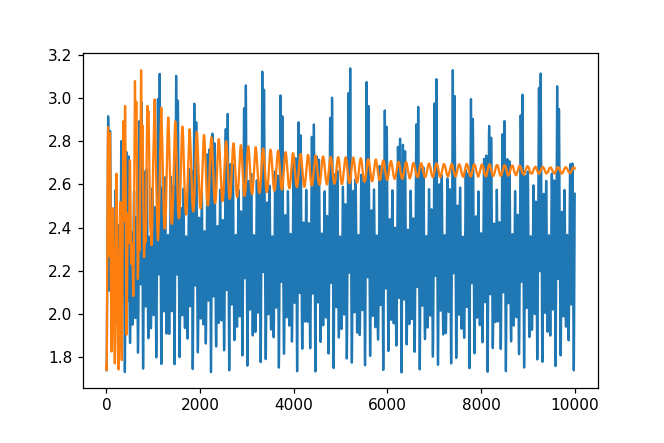

In [152]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(θ1_c)
plt.plot(θ1_q)
plt.show()

<IPython.core.display.Javascript object>


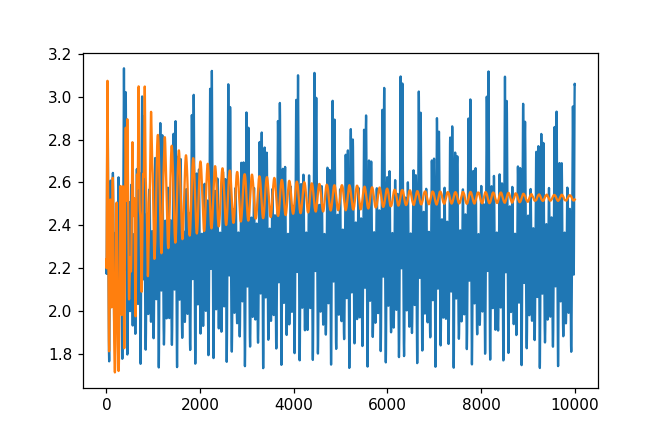

In [153]:
plt.figure()
plt.plot(θ2_c)
plt.plot(θ2_q)
plt.show()

<IPython.core.display.Javascript object>


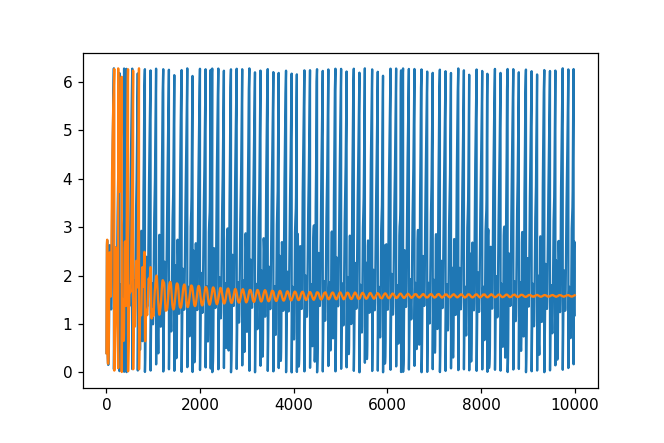

In [154]:
ϕ1_c = np.mod(ϕ1_c, np.pi * 2)

plt.figure()
plt.plot(ϕ1_c)
plt.plot(ϕ1_q)
plt.show()

<IPython.core.display.Javascript object>


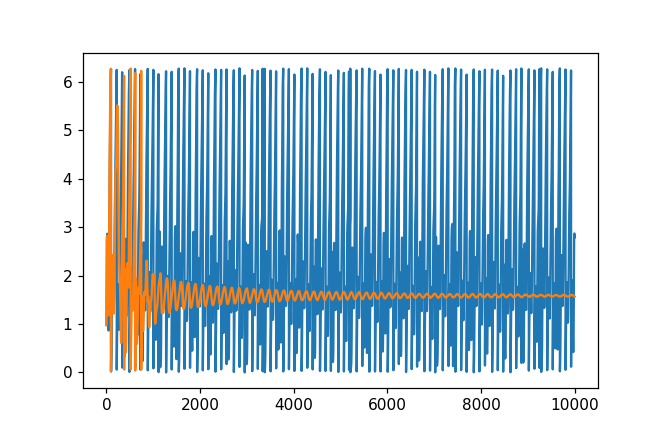

In [155]:
ϕ2_c = np.mod(ϕ2_c, np.pi * 2)

plt.figure()
plt.plot(ϕ2_c)
plt.plot(ϕ2_q)
plt.show()